## MKVTBKG: Creating a background map from Voronoi and Delaunay Tesselation of Individual Events
### Original spec by John C. Houck. Adapted and Modified in Python by Rafael Martínez-Galarza. February 2022.

This notebook is a demonstration implementation of John Houck's "Constructing Background Images using Voronoi Tessellation" specification [document](https://cxc.harvard.edu/csc/memos/files/Houck_mkvtbkg.pdf), done using Python code. The algorithm constructs a backgroud image directly from the event files using the following steps:

* First, it computes the Voronoi tesselation of the individual space on the physcial space of the detector.
* Then, it computes the area of each Voronoi polygon and separates them between source polygons and background polygons using an area threshold ($\alpha_{\rm{thres}}$).
* Using only the events corresponding to background polygons, it computes the Delaunay triagnulation of the background space.
* The cont density at the location of each background event (i.e. at each vertex of the Delaunay simplices) is estimated as a linear combination of the areas of all the simplices of which the point in question is a vertex.
* Finally, the counts in each pixel are obtained by integrating the set of Dealunay point estimates in each pixel.

This demonstration prototype does not yet account for the exposure map. The implementation below uses an evt3 or evt2 file as an inpput.

Most of the relevant packages for plane topology are part of the *scipy* library. We also use *astropy* for dealing with the FITS event files, and *itertools* for efficient looping over polygons.

Let's start by doing the relevant imports.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import Voronoi, voronoi_plot_2d
import scipy.special as sc
from scipy.optimize import curve_fit
from astropy.io import fits
import time

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load data and construct Voronoi polygons
The Voronoi diagram of a set of points on the plane with coordinates ${(x_i, y_i)}$ is a partition of that plane in polygons such that for point $i$, the corresponfing Voronoi region is the region containing all the points that are closer to point $i$ than to any other point. For our purposes, the points (or seeds) will be the chip coordinates (or physical coordinates) of the incmoing X-ray events on the plane of the detector, which are recorded in the event file. We therefore start by reading an event file. In this demonstration we will be using the evt3 file corresponding to ObsID 4634, which is an observation of the the Cas A supernova remnant. We first load the fits file.

In [153]:
# Load event file
hdu = fits.open('acisf04395_000N020_evt3.fits')

In [3]:
# Load exposure map file
hdu0 = fits.open('acisf04395_000N027_b_exp3.fits')

In [4]:
# Load background map file
hdu1 = fits.open('acisf04395_000N020_b_bkgimg3.fits')

In [5]:
# Load FOV map file
hdu2 = fits.open('acisf04395_000N020_fov3.fits')

In [6]:
# Normalized exposure map
hdu[1].data['ccd_id']

array([3, 3, 3, ..., 6, 6, 6], dtype=int16)

### Generating a normalized effective area map
Ideally, one wants to account for the varying effective area across the field by multiplying the geometric area of each polygon by the corresponding normalized effective area that comes from the exposure map (basically the normalized exposure map). One could do it at this stage. However, mkvtbkg does it at the end, by multiplying the resulting background map by the exposure map. It is worth thinking whether that is the best way of doing it, or if it better to do it at this stage. For now, we go with the former option and do not correct for the effective area.

In [7]:
# Generate a map of effective area

exp_norm1 = hdu0[0].data #/hdu1[0].header['EXPOSURE']
exp_norm2 = exp_norm1
exp_norm3 = exp_norm2/np.max(exp_norm2)
exp_norm3.reshape(np.shape(hdu0[0].data))

print(np.sum(exp_norm2/np.sum(exp_norm2)))

0.9999999


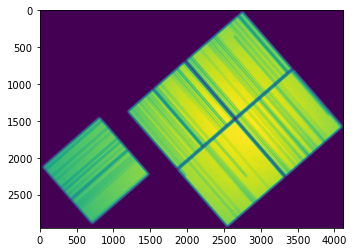

In [8]:
plt.imshow(exp_norm3)

In [65]:
hdu_v = fits.PrimaryHDU(exp_norm3,header=hdu0[0].header)
hdu_v.writeto('norm_eff_area.fits')


Let's find out how many events are contained in this file, by extracting all of the $x$ coordinates and measuring the lenght of the resulting array.

In [9]:
print('There are '+str(len(hdu[1].data['x']))+'events in the loaded file')

There are 940057events in the loaded file


We now create an array that contains the coodinates on the plane of all the events. But we make sure that we select events is a given chip, here, we will pick CCD_ID = 3

In [10]:
events = np.array(list(zip(hdu[1].data['x'][np.where(hdu[1].data['ccd_id']==3)],hdu[1].data['y'][np.where(hdu[1].data['ccd_id']==3)])))

We use *scipy*'s [Voronoi](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html) class to generate the Voronoi regions for the set of points we have just extracted. For demonstration purposes, in this notebook we will only use the first $10^6$ evetns recorded. We the plot the full set of resulting Voronoi region using *voronoi_plor_2d*:

In [11]:
start = time.time()
#vor = Voronoi(events[0:10000])
vor = Voronoi(events)
end = time.time()
print('Time ellapsed: ',end - start) 

Time ellapsed:  6.797653913497925


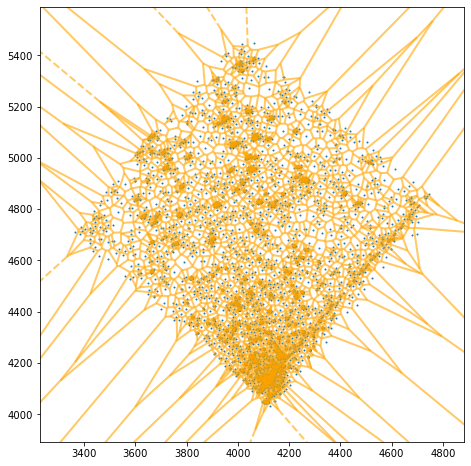

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
voronoi_plot_2d(vor,ax,show_vertices=False, line_colors='orange',
                line_width=2, line_alpha=0.6, point_size=2)
ax.set_aspect('equal')

Let's take a closer look at the regions created, in two different regions of the map. The one to the right corresponds to the location of the pulsar

(4131.0, 4132.0)

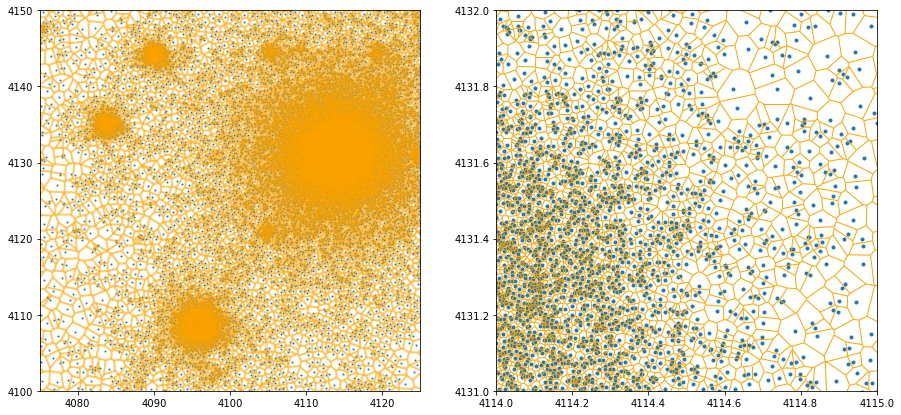

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,15))

voronoi_plot_2d(vor, axs[0],show_vertices=False, line_colors='orange',
                line_width=2, line_alpha=0.6, point_size=2)
axs[0].set_aspect('equal')
axs[0].set_xlim(4075,4125)
axs[0].set_ylim(4100,4150)

voronoi_plot_2d(vor, axs[1],show_vertices=False, line_colors='orange')
axs[1].set_aspect('equal')
axs[1].set_xlim(4114,4115)
axs[1].set_ylim(4131,4132)

### Estimating the polygon areas and separating sources from background
At the core of the mkvtbkg algorithm is its ability to distinguish between regions of the map dominated by background events, and those dominated by source events. As can be inferred from the plots above, whether a polygon is a source polygon as opposed to a background polygon depends on the polygon area. Polygons that are close to a point source tend to have smaller areas, because the events in that part of the map are closer to each other. Background polygons, on the other hand, have larger areas. So, we now define a function that takes the coordinates of the vertices of a polygone and estimates the area of the polygon. 

In [12]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

We now use this function to estimate the area of all the Voronoi polygons that we have created from the event files, and plot a histogram showing their distribution:

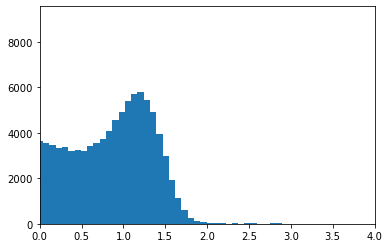

In [100]:
areas = []  # This array will contain the areas

for i, point_reg in enumerate(vor.point_region):   # Loop over Voronoi regions
    polygon = vor.vertices[vor.regions[point_reg]]  # Get the vertices
    area = PolyArea(polygon.T[0],polygon.T[1])      # Calculate the area
    areas.append(area)
    
# Now plot the histogram
counts, bins, bars = plt.hist(np.log10(np.array(areas)[np.where(np.array(areas)!=0)]),bins=200)
#counts, bins, bars = plt.hist(np.array(areas)[np.where(np.array(areas)!=0)],bins=30)

#plt.yscale('log')
plt.xlim(0,4)
plt.show()

In [147]:
cuentas = np.log10(counts)
#cuentas = counts
cuentas[np.where(cuentas == -inf)] = 0.0
#print(cuentas)

### Fitting the large area tail of the distribution with a Gamma function

The distribution of large polygon areas converges to a incomplete gamma function. We can then iteratively fit the long tail until it converges to a mean area, which is representative of the background level. We start by calling the incomplete gamma function from scipy, and then we fit it to the histogram bins.

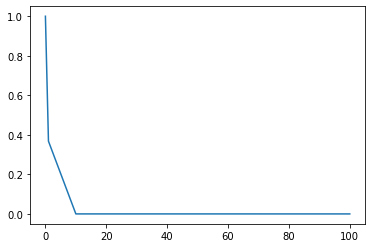

In [52]:
sc.gammaincc(1, [0, 1, 10, 100])
plt.plot(np.array([0.,1,10,100]),sc.gammaincc(1, [0., 1, 10, 100]))
#print()

In [53]:
def inc_gamma(x, a, b):
    return b*sc.gammaincc(a,x)

In [54]:
print(inc_gamma([0, 1, 10, 100],4,1))

[1.00000000e+00 9.81011843e-01 1.03360507e-02 6.38988770e-39]


In [80]:
limit = 94
param = curve_fit(inc_gamma, bins[limit:-1], cuentas[limit:])

In [81]:
param[0]

array([1.29143001, 9.6637062 ])

We need to select an appropriate area threshold below which a polygon will be considered to belong to a source. Rigurourly, this should be done by first finding an appropriate mean area of the polygons, $\bar{a}$, and then selecting source polygons as those having an area $a < \alpha_{\rm{thres}}\bar{a}$, with $\alpha_{\rm{thres}}$ typically having a value of 0.25. The mean area is determined by iteratively fitting a Gamma function to the large area tail of the distribution, as we have done above. The fit give a parameter for the incomplete Gamma function of $10^{1.3}$. This should be a representative value of the mean polygon area for backfround polygons. This is mostly true when most of the chip is covered with background events. We will the adopt $a < 0.25*19.95 = 4.98$ as the threshold to separate source polygons from backfround polygons. Let's first look at the Gamma function fit, and then look at how the polygons are selected:


**I think in order to replace the source photons with a uniform distribution, I need to accept them or rejected them with a probability proportional to the are of the corresponding polygon. Need to calibrate that so that the level is the same as the local background**



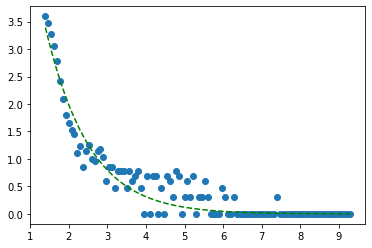

In [82]:
plt.plot(bins[limit:-1], inc_gamma(bins[limit:-1], param[0][0], param[0][1]), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f')
plt.scatter(bins[limit:-1],cuentas[limit:])

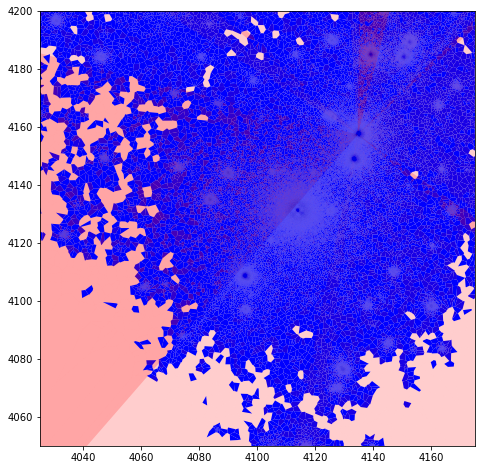

Time ellapsed:  358.2438111305237


In [84]:
# Set the threshols
alpha_thres = 0.25   # We keep the alpha value a free parameter of the model
thres = alpha_thres*(10**param[0][0])

src_cnts = []   # This array will contain the coordinates of source events 
bkg_cnts = []   # This array will contain the coordinates of source events 


start = time.time()


fig, ax = plt.subplots(figsize=(8,8))

# Loop over all Voronoi regions
for i,point_reg in enumerate(vor.point_region):
    
    # Get the vertices of each polygon
    polygon = vor.vertices[vor.regions[point_reg]]
    #if ((np.min(polygon[:,0])>4025) & (np.max(polygon[:,0])<4175) & (np.min(polygon[:,1])>4050) & (np.max(polygon[:,1])<4200)):
    # Separate between source and background polygons based on the areas
    if (areas[i] < thres):
        src_cnts.append(vor.points[i])
        ax.fill(*zip(*polygon), 'blue')
    elif ((areas[i] >= thres) ):
        bkg_cnts.append(vor.points[i])
        ax.fill(*zip(*polygon), 'red', alpha=0.1)
    else:
        continue        
        
ax.set_aspect('equal')
ax.set_xlim(4025,4175)
ax.set_ylim(4050,4200)
    
#axs[0,1].set_aspect('equal')
#axs[0,1].set_xlim(4174,4184)
#axs[0,1].set_ylim(3807,3817)
    
#axs[1,0].set_aspect('equal')
#axs[1,0].set_xlim(4239,4249)
#axs[1,0].set_ylim(4016,4026)
    
#axs[1,1].set_aspect('equal')
#axs[1,1].set_xlim(4174,4184)
#axs[1,1].set_ylim(3807,3817)    
    
    
plt.show()        
        
end = time.time()
print('Time ellapsed: ',end - start) 
    


In [90]:
#thres = 0.5

#fig, axs = plt.subplots(2,2, figsize=(15,15))

#voronoi_plot_2d(vor, axs[0,0],show_vertices=False, line_colors='orange',
#                line_width=1, line_alpha=0.5, point_size=0)

#voronoi_plot_2d(vor, axs[0,1],show_vertices=False, line_colors='orange',
#                line_width=1, line_alpha=0.5, point_size=1)

#voronoi_plot_2d(vor, axs[1,0],show_vertices=False, line_colors='orange',
#                line_width=1, line_alpha=0.5, point_size=1)

#voronoi_plot_2d(vor, axs[1,1],show_vertices=False, line_colors='orange',
#                line_width=1, line_alpha=0.5, point_size=1)




#axs[0,0].set_aspect('equal')
#axs[0,0].set_xlim(3900,4400)
#axs[0,0].set_ylim(3600,4100)
    
#axs[0,1].set_aspect('equal')
#axs[0,1].set_xlim(3970,4030)
#axs[0,1].set_ylim(3797,3857)
    
#axs[1,0].set_aspect('equal')
#axs[1,0].set_xlim(3980,4040)
#axs[1,0].set_ylim(3720,3780)
    
#axs[1,1].set_aspect('equal')
#axs[1,1].set_xlim(4030,4090)
#axs[1,1].set_ylim(3860,3920)    
    
    
#plt.show()

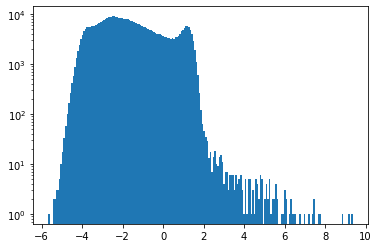

In [17]:
plt.hist(np.log10(np.array(areas)[np.where(np.array(areas)!=0)]),bins=200)
plt.yscale('log')
#plt.xlim(-2.0,0)
plt.show()

We can now plot the coordinats of individual events, and color code them according to whether they are source or background events.

In [145]:
#src_cnts

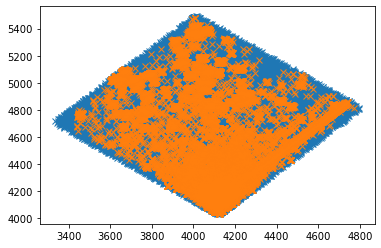

In [86]:
plt.plot(np.array(bkg_cnts).T[0], np.array(bkg_cnts).T[1], 'x')
plt.plot(np.array(src_cnts).T[0], np.array(src_cnts).T[1], 'x')
#plt.xlim(4170,4190)
#plt.ylim(3800,3820)

In [93]:
len(bkg_cnts)

19243

### Construction a background map using Delaunay triangulation.
Let's first note that that before we construct a background map using Delauney triangles as shown below, we should first replace the region containing source polygons with a uniform distribution of count that matches the local background, as described in the mkvtbkg spec. We have not yet implemented this part in this prototype. Below we construct the backround maps using only events that fall in bakcground regions (as set by the threshold parameter).

The idea behind the construction of the background image from the triangles is as follows: the Delaunay Triangulation Field Estimator (DTFE) provides the count density at any spatial point based on the areas of the triangles. Specifically, the density at any point is interpolated from the density at the triangle vertices

In [128]:
#points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
from scipy.spatial import Delaunay
start = time.time()
tri = Delaunay(bkg_cnts)
end = time.time()
print('Time ellapsed: ',end - start) 

Time ellapsed:  0.721325159072876


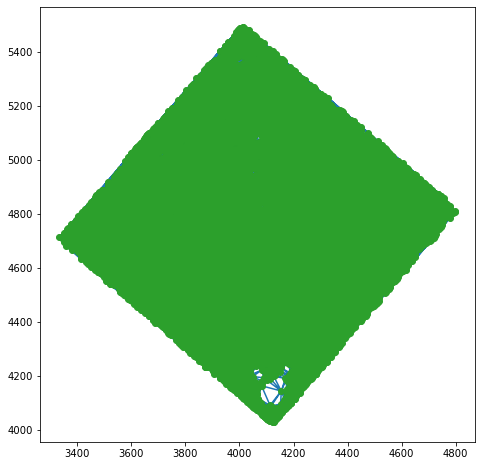

In [129]:
fig, ax = plt.subplots(figsize=(8,8))
ax.triplot(np.array(bkg_cnts)[:,0], np.array(bkg_cnts)[:,1], tri.simplices)
ax.plot(np.array(bkg_cnts)[:,0], np.array(bkg_cnts)[:,1], 'o')  
ax.set_aspect('equal')
#ax.set_xlim(3900,4100)
#ax.set_ylim(3727,3927)


#plt.triplot(np.array(bkg_cnts)[:,0], np.array(bkg_cnts)[:,1], tri.simplices)
#plt.plot(np.array(bkg_cnts)[:,0], np.array(bkg_cnts)[:,1], 'o')  
#plt.axes('equal')
#plt.xlim(3989,4009)
#plt.ylim(3899,3919)
plt.show()

In [130]:
def get_simplices(self, vertex):
    "Find all simplices this `vertex` belongs to"
    visited = set()
    queue = [self.vertex_to_simplex[vertex]]
    while queue:
        simplex = queue.pop()
        for i, s in enumerate(self.neighbors[simplex]):
            if self.simplices[simplex][i] != vertex and s != -1 and s not in visited:
                queue.append(s)
        visited.add(simplex)
    return np.array(list(visited))

In [131]:
start = time.time()
print(len(tri.points))
sigma_kas = []
for i in range(len(tri.points)):
    neigh_triangles = get_simplices(tri, i)
    sum_areas = 0
    for triangle in neigh_triangles:
        vertex = tri.points[tri.simplices[triangle]]
        area = PolyArea(vertex.T[0],vertex.T[1])
        sum_areas += area
    sigma_k = 3.0/sum_areas
    sigma_kas.append(sigma_k)
    #print(sigma_k)
end = time.time()
print('Time ellapsed: ',end - start) 

57269
Time ellapsed:  14.564959049224854


In [132]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sys import argv

x = tri.points.T[0]
y = tri.points.T[1]
z = sigma_kas

#fig = plt.figure()
#ax = Axes3D(fig)
#surf = ax.plot_trisurf(x, y, np.log10(z), cmap=cm.jet, linewidth=0.1)
#fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.savefig('teste.pdf')
plt.show()

In [133]:
#x0 = np.arange(3800,4600, 2)
#y0 = np.arange(3500,4300, 2)

x0 = np.arange(3400,4800, 2)
y0 = np.arange(4000,5500, 2)



Xi, Yi = np.meshgrid(x0, y0)

In [134]:
from itertools import product

start = time.time()
#bkg_map = numpy.zeros(shape=(len(x0),len(x0)))
bkg_map = []
dx = dy = 2
z = np.array(z)
for posx, posy in product(x0, y0):
    #bkg_map.append(np.sum(np.array(z)[np.where((x > posx) & (x<= posx+dx) & (y > posy) & (y<= posy+dy))]))
    bkg_map.append(np.sum(z[(x > posx) & (x<= posx+dx) & (y > posy) & (y<= posy+dy)]))
end = time.time()
bkg_map = np.array(bkg_map).reshape((len(x0),len(y0)))
print('Time ellapsed: ',end - start) 

Time ellapsed:  85.34093189239502


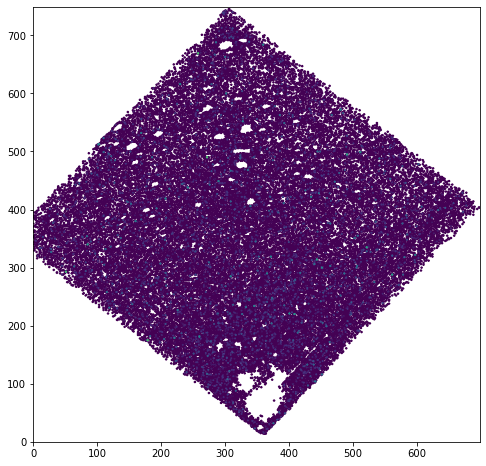

In [151]:
fig, ax = plt.subplots(figsize=(8,8))
#ax.imshow(np.log10(bkg_map.T+0.1),interpolation='spline16')
ax.contour(bkg_map.T)
#ax.invert_yaxis()
#ax.set_title('Event image, bin = 2')
#plt.savefig('bkg_img_casA_bin2_a10.pdf',dpi=300)

In [138]:
bkg_img_log_a0p5 = np.log10(bkg_map.T+0.1)
#bkg_img_log_a0p5 = bkg_map.T
#np.save('bkg_img_casA_log_bin2_a0p5_1Ecnts.npy',bkg_img_casA_log_a0p5)

Text(0.5, 1.0, 'Background image')

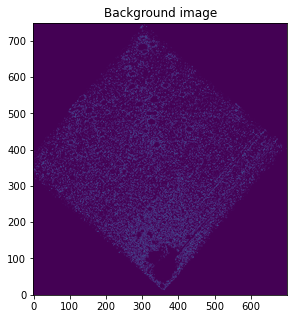

In [142]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow(bkg_img_log_a0p5,interpolation='spline36')
axs.invert_yaxis()
axs.set_title('Background image')

In [126]:
hdu_src = fits.PrimaryHDU(bkg_img_log_a0p5,header=hdu[0].header)
hdu_src.writeto('proto_srcmap2.fits')

### Example with Cas A

For demonstration purposes, below is an examople of the performace of the prototype with CasA

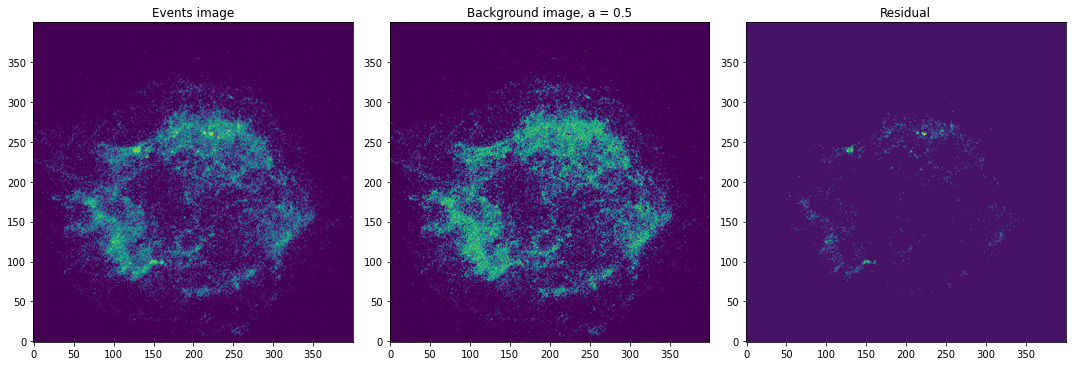

In [27]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(evt_img_log,interpolation='spline16')
axs[0].invert_yaxis()
axs[0].set_title('Events image')
axs[1].imshow(bkg_img_log,interpolation='spline16')
axs[1].invert_yaxis()
axs[1].set_title('Background image, a = 0.5')
axs[2].imshow(evt_img_log-bkg_img_log,interpolation='spline16')
axs[2].invert_yaxis()
axs[2].set_title('Residual')
plt.tight_layout()
#plt.savefig('mkvtbkg_casA_bin2_a0p5_v1.pdf',dpi=300)

In [33]:
bkg_img_casA_log_a0p5 = np.log10(bkg_map.T+0.1)
np.save('bkg_img_casA_log_bin2_a0p5.npy',bkg_img_casA_log_a0p5)

In [65]:
areas = []
for vertex in tri.points[tri.simplices]:
    area = PolyArea(vertex.T[0],vertex.T[1])
    areas.append(area)

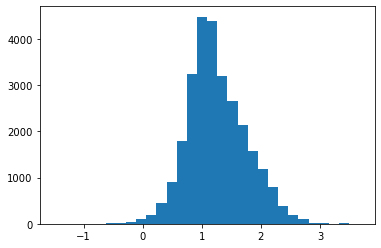

In [66]:
plt.hist(np.log10(areas),bins=30)
plt.show()

In [43]:
len(areas)

2925

In [23]:
def get_simplices(self, vertex):
    "Find all simplices this `vertex` belongs to"
    visited = set()
    queue = [self.vertex_to_simplex[vertex]]
    while queue:
        simplex = queue.pop()
        for i, s in enumerate(self.neighbors[simplex]):
            if self.simplices[simplex][i] != vertex and s != -1 and s not in visited:
                queue.append(s)
        visited.add(simplex)
    return np.array(list(visited))

In [ ]:
def find_neighbors(pindex, triang):
    return triang.vertex_neighbor_vertices[1][triang.vertex_neighbor_vertices[0][pindex]:
                                              triang.vertex_neighbor_vertices[0][pindex+1]]